# Vector *.VEC Read and Clean [xrWrap]
I'm moving a bunch of code that was in 4 seperate python files in the sandpit over to notebooks. 



## Step 0
Merge ADV files [if necessary]. I'm not doing this here, hence it is step zero, but it is generally necessary in practice. Example code:

```
table =[[6329, 5],
        [6329, 6],
        [6329, 7],
        [6329, 4],
        ]

root = r"//drive.irds.uwa.edu.au/CEME-BBLE-001/RS19/DATA/L150/ADV/6329"
root2 = r"\\drive.irds.uwa.edu.au\ECM-OFFHUBP1-001\DATA\FIELD\2019_RowleyShoals\data\moored_instrument_data\raw_data\L150\ADV\6329"
with  open(root + '/6329_combined.vec', 'wb') as wf:
    for row in table:
        with open(r'{}/{}0{}.VEC'.format(root2, row[0], row[1]) , 'rb') as rf:
            print(1)
            wf.write(rf.read())
```

## Step 1
Read with Dall's porpoise.

- This Dall's porpoise situation is suboptimal. It is basically a hack of Dolfyn I needed to make to read data from the 2019 Rowley Shoals Experiment. The original creator LKilcher is probably not appropriately credited. Amend this.  

- Dall's Porpoise is going to produce a lot of text output. Another thing to consider fixing. 

#### Why Dall's porpoise
I made this Dall's porpoise library because I was struggling with using Dolfyn for the 2019 Rowley Shoals experiment. Reading VEC files in Dall's Porpoise differs from Dolfyn in two main ways:
 
1. It handles certain file corruptions. Namely, header data and user data blocks that are in the wrong place. As long as it finds them at some point it will be OK.

1. It allows for streaming the data to NETCDF

    - If streaming, however, it doesn't really produce the dat object very well
    - It is supposed to return a dat for the final chunk, but I'm not sure that this actually works

Here I'm going to set `stream=FALSE` to read the entire thing to dat.

#### File choice
I'm going to use file `601903.VEC`. This was the first file from 2017 KISSME deployment in the Browse Basin. With 10000000 ensembles we'll see a lot of initial noise where the instrument was on the boat, and then some pretty significant phase wrapping. This allows us to test:
1. Unwrapping code. 
2. Conversion between BEAM, XYZ and ENU

In [3]:
import os, datetime
import dallsporpoise
import matplotlib.pyplot as plt
import numpy as np
import importlib, turbo_tools
from pIMOS.xrwrap.NORTEK_VECTOR import NORTEK_VECTOR, num2date_lk

fullpath = r'../../pIMOS_samples/KISSME samples/NortekVector/601903.VEC'
os.path.exists(fullpath)

True

In [ ]:
%%time
nens = 10000000

# rr = NORTEK_VECTOR(os.path.split(fullpath)[0], os.path.split(fullpath)[1], nens=10000, driver='dallsporpoise')
rr = NORTEK_VECTOR(os.path.split(fullpath)[0], os.path.split(fullpath)[1], nens=[10000000, 20000000], driver='dallsporpoise')


['601903.VEC']
0
Reading [10000000, 20000000] ensembles
Reading vec with <module 'dallsporpoise' from 'c:\\users\\azulberti\\dropbox\\university\\phd\\03_code\\source_code_offpath\\dallsporpoise\\dallsporpoise\\__init__.py'>
2 of 1178599425 (1.7e-07%)
Reading file. 2 of 1178599425 (1.7e-07%)
Found hardware config at 0
Not convinced this is reading correctly
Found head config at 48
Found user config at 272
Reading user config at 272
Done
Scanned common
Initialising ADV
Setting chunk_size to 64000
Continuous mode - happy days. 
Scanning ADV
MPLTIME NOT IN DAT, INITIALISING
VEL NOT IN DAT, INITIALISING


c:\users\azulberti\dropbox\university\phd\03_code\source_code_offpath\dallsporpoise\dallsporpoise\imp\nortek_vector.py:193: UserWarning: a 'start ensemble' is not yet supported for the Nortek reader. This function will read the entire file, then crop the beginning at nens[0].
  warnings.warn("a 'start ensemble' is not yet supported "


c has reset.
11786002 of 1178599425 (1.0%)
Reading file. 11786002 of 1178599425 (1.0%)
23571994 of 1178599425 (2.0%)
Reading file. 23571994 of 1178599425 (2.0%)
35357986 of 1178599425 (3.0%)
Reading file. 35357986 of 1178599425 (3.0%)
47143978 of 1178599425 (4.0%)
Reading file. 47143978 of 1178599425 (4.0%)
58929990 of 1178599425 (5.0%)
Reading file. 58929990 of 1178599425 (5.0%)
70715982 of 1178599425 (6.0%)
Reading file. 70715982 of 1178599425 (6.0%)
82501974 of 1178599425 (7.0%)
Reading file. 82501974 of 1178599425 (7.0%)
94287966 of 1178599425 (8.0%)
Reading file. 94287966 of 1178599425 (8.0%)
106073958 of 1178599425 (9.0%)
Reading file. 106073958 of 1178599425 (9.0%)
117859946 of 1178599425 (10.0%)
Reading file. 117859946 of 1178599425 (10.0%)
129645938 of 1178599425 (11.0%)
Reading file. 129645938 of 1178599425 (11.0%)
141431954 of 1178599425 (12.0%)
Reading file. 141431954 of 1178599425 (12.0%)
153217946 of 1178599425 (13.0%)
Reading file. 153217946 of 1178599425 (13.0%)
1650039

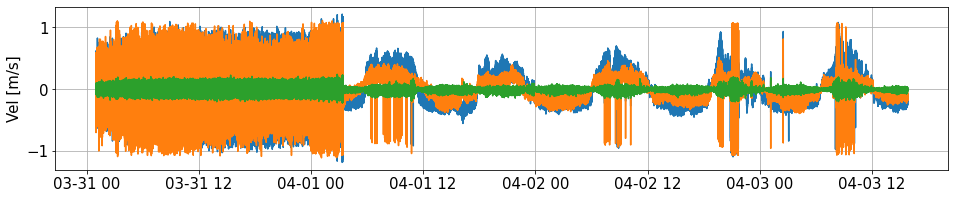

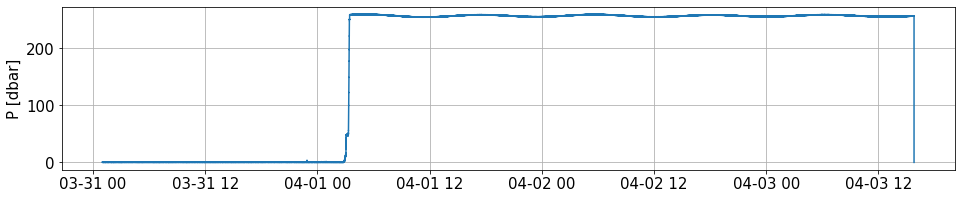

In [3]:
plt.figure(figsize=(16, 3))
plt.plot(rr.ds.datetime, rr.ds.vel_dolfyn[0, :])
plt.plot(rr.ds.datetime, rr.ds.vel_dolfyn[1, :])
plt.plot(rr.ds.datetime, rr.ds.vel_dolfyn[2, :])
plt.ylabel('Vel [m/s]')
plt.grid()

plt.figure(figsize=(16, 3))
plt.plot(rr.ds.datetime, rr.dat.env.pressure)
plt.ylabel('P [dbar]')
plt.grid()

In [4]:
# Plot XYZ again
def pto_plot(pto, type='xyz', xl=None):
    if type in ['xyz', '*']:
        plt.figure(figsize=(16, 3))
        plt.plot(pto.time, pto.vel_x)
        plt.plot(pto.time, pto.vel_y)
        plt.plot(pto.time, pto.vel_z)
        plt.ylabel('Vel [m/s]')
        plt.grid()
        if xl is None:
            plt.xlim([pto.time[0], pto.time[-1]])
        else:
            plt.xlim(xl)
        plt.ylim([-1, 1])
        plt.title('XYZ')
        
    if type in ['enu', '*']:
        plt.figure(figsize=(16, 3))
        plt.plot(pto.time, pto.vel_enu[0, :])
        plt.plot(pto.time, pto.vel_enu[1, :])
        plt.plot(pto.time, pto.vel_enu[2, :])
        plt.ylabel('Vel [m/s]')
        plt.grid()
        if xl is None:
            plt.xlim([pto.time[0], pto.time[-1]])
        else:
            plt.xlim(xl)
        plt.ylim([-1, 1])
        plt.title('ENU')
        
    if type in ['beam', '*']:
        plt.figure(figsize=(16, 3))
        plt.plot(pto.time, pto.vel_beam[0, :])
        plt.plot(pto.time, pto.vel_beam[1, :])
        plt.plot(pto.time, pto.vel_beam[2, :])
        plt.ylabel('Vel [m/s]')
        plt.grid()
        if xl is None:
            plt.xlim([pto.time[0], pto.time[-1]])
        else:
            plt.xlim(xl)
        plt.ylim([-0.25, 0.25])
        plt.title('BEAM')
    

# Steps 2-4
Do this all in one function.....

Using the super NORTEK_VECTOR(xrwrap).to_pto method

#### Step 2 Initialise point turbulence class


#### Step 3 Set H.P.R. [Correct pitch and roll here if necessary]

This is a shortcut. In this library I just use a single H.P.R. value for a full file. This is OK for moored instruments.

The tilt sensor failed for the 6019 instrument in the 2017 KISSME exmerpient. In both pitch AND roll. The corrections were determined by measurements made on the deployment, and the measured pitch and roll from the 6329 instrument. The best correction is:

`pitch = 0.3349`\
`roll = 1.9945`


#### Step 4 Set head transformation matrix.

In [5]:
%%time
import warnings

start = datetime.datetime(2017, 4, 2, 0, 0, 0, 0)
end = datetime.datetime(2017, 4, 3, 0, 0, 0, 0)

h = None
p = None
r = None

warnings.warn('APPLY TO KISSME 6019 ONLY!!!')
p = 0.3349
r = 1.9945

# pto = rr.to_pto( pitch=p, roll=r, heading=h, ori='up')
pto = rr.to_pto(date_lims=[start, end], pitch=p, roll=r, heading=h, ori='up')


<timed exec>:10: UserWarning: APPLY TO KISSME 6019 ONLY!!!
c:\users\azulberti\dropbox\university\phd\03_code\source_code\turbo_tools\turbo_tools\utils\time.py:182: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ans = linspacetime(pd.datetime.today(), pd.datetime.today()+datetime.timedelta(1), n=100)
c:\users\azulberti\dropbox\university\phd\03_code\source_code\turbo_tools\turbo_tools\utils\time.py:189: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  ans = linspacetime(pd.datetime.today(), pd.datetime.today()+dt, dt_s=dt_s)


<class 'datetime.datetime'>
Module tested
<class 'datetime.datetime'>
Time vector is well spaced
<class 'numpy.datetime64'>
Time vector is well spaced
There are 101 elements in this 10 second period spaced at 0.1.
Time Module OK
[[ 6.123234e-17 -1.000000e+00  0.000000e+00]
 [ 1.000000e+00  6.123234e-17  0.000000e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00]]
Initialising with length 5529438
<class 'numpy.datetime64'>
Time vector is well spaced
Initialised.
Wall time: 600 ms


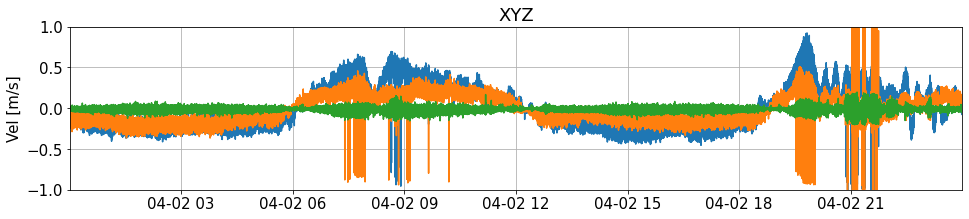

In [6]:
pto_plot(pto)

# Step 5 Fix Phase Wrapping
Inputs are:
1. Block length [L]
1. Ambiguity velocity 

The algorithm is as follows:
1. Select a block length [L] for the unwrapping. Rule of thumb, the shorter the better yet need enough data points to make sure that we can reliably detect 'spikes' from the rest of the population.
2. Loop through in chunks of length [L], do a test unwrap, if it lowers the variance assume it was wrapped and apply the correction, if not, keep the raw data.  
    1. Calculate variance of block [VR]
    1. Measure spikes [difference between blocks]
    1. Find largest spike
    1. Find midpoint of this largest spike. 
    1. Split the population in two based on this midpoint
    1. Shift one sub-population by one phase velocity to be closer to the other in value
    1. Calculate variance of modified block [VM]
    1. If VM\<VR assume you were wrapped, shift the modified population by whichever number of ambiguity velocities gives you the best match to the previous block [if it is the first block just keep the median as close as possible to the raw median]
    1. If VM\>VR do nothing
    
The assumption here is that this midpoint will represent a seperation between the wrapped and the unwrapped 'populations'. If the data are so wrapped that they wrap back into themselves [i.e. you're wrapped by more than one ambiguity velocity, then you're in trouble]

It also assumes that he first block is not heavily wrapped. Can get into trouble that way also.

### Start this on a small record
Have a look at the example plots from Matlab:


In [7]:
start = datetime.datetime(2017, 4, 2, 8, 40, 0, 0)
end_desired = datetime.datetime(2017, 4, 2, 8, 50, 0, 0)

end = end_desired + datetime.timedelta(minutes=10) # Need to go a bit longer than I want

pto_small = rr.to_pto(date_lims=[start, end], pitch=p, roll=r, heading=h, ori='up')

Initialising with length 76797
<class 'numpy.datetime64'>
Time vector is well spaced
Initialised.


[[ 2.68017578 -1.34936523 -1.32861328]
 [-0.0126953   2.34399414 -2.33349609]
 [ 0.34130859  0.34790039  0.3425293 ]]
This still needs to be confirmed
This still needs to be confirmed
This still needs to be confirmed


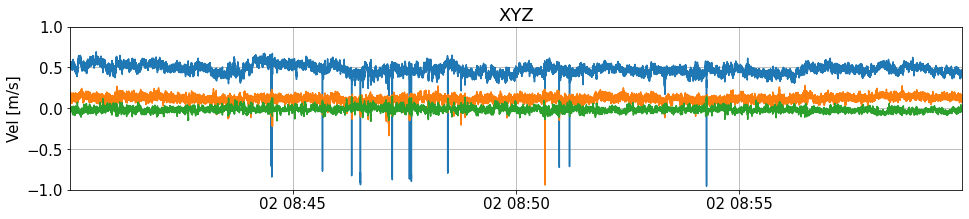

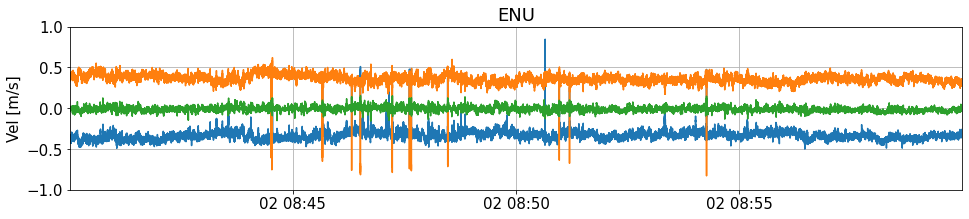

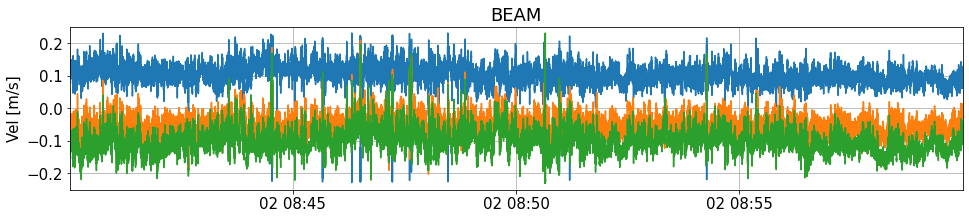

In [8]:
print(pto_small.BEAM_2_XYZ)
pto_plot(pto_small, '*')

This still needs to be confirmed
Unwrapping 0
Doing incomplete block.
Phase unwrapping comlete.
Nans in the intial data set: 0
Despiking 0
Despiking 1
Despiking 2
Despiking 3
Despiking 4
Despiking 5
Despiking 6
Despiking 7
Despiking 8
This still needs to be confirmed
This still needs to be confirmed
This still needs to be confirmed


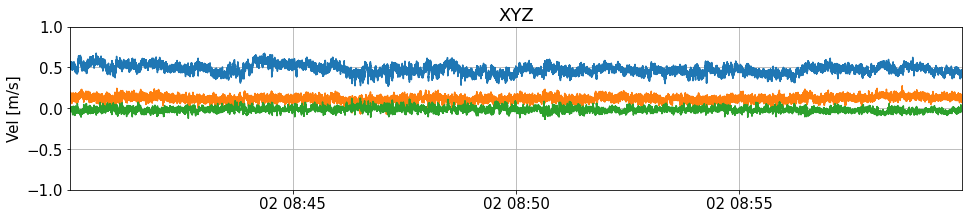

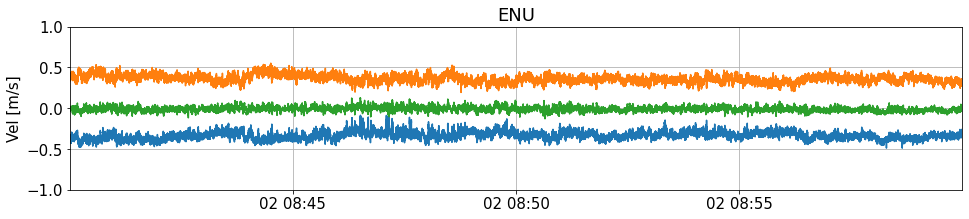

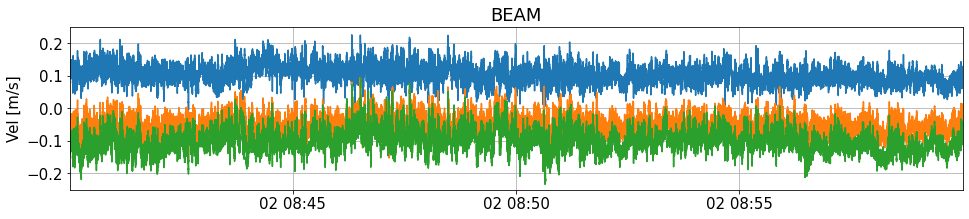

In [9]:
pto_small.clean_unwrap(block_length_seconds=600)
pto_small.clean_despike(block_length_seconds=120)
pto_plot(pto_small, '*')

### Compare the above to the MATLAB output for the same period
![title](../figures/matlab_comparison_figures/adv_processing_2_april/KISSME_April_2_6019_ADV_Raw_vs_Clean_[10_mins_from_0840].png)

#### Try another block

In [10]:
start = datetime.datetime(2017, 4, 2, 19, 40, 0, 0)
end_desired = datetime.datetime(2017, 4, 2, 19, 50, 0, 0) 

end = end_desired + datetime.timedelta(minutes=11) # Need to go a bit longer than I want

pto_small = rr.to_pto(date_lims=[start, end], pitch=p, roll=r, heading=h, ori='up')
# # USE SAME INFO FROM ABOVE


Initialising with length 80638
<class 'numpy.datetime64'>
Time vector is well spaced
Initialised.


### The one day error in the plotting is good now.

In [21]:
xl = [start, end_desired]
# xl = [start, end]

[[ 2.68017578 -1.34936523 -1.32861328]
 [-0.0126953   2.34399414 -2.33349609]
 [ 0.34130859  0.34790039  0.3425293 ]]
This still needs to be confirmed
This still needs to be confirmed
This still needs to be confirmed


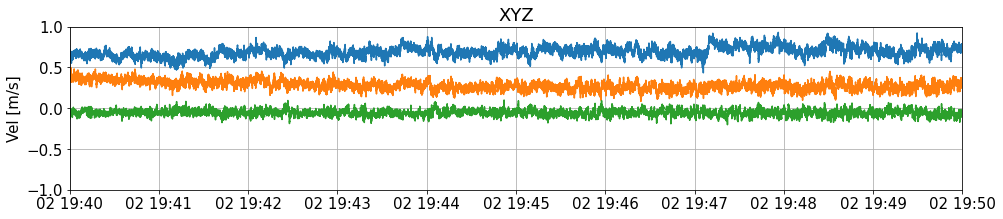

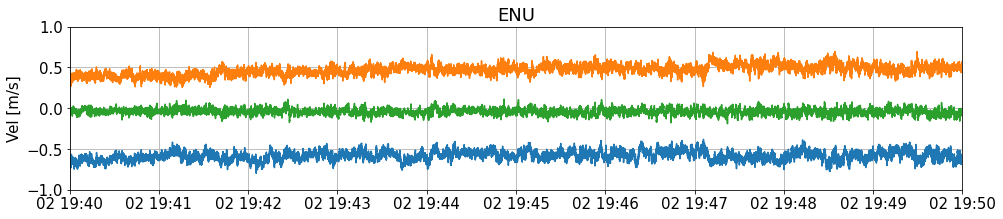

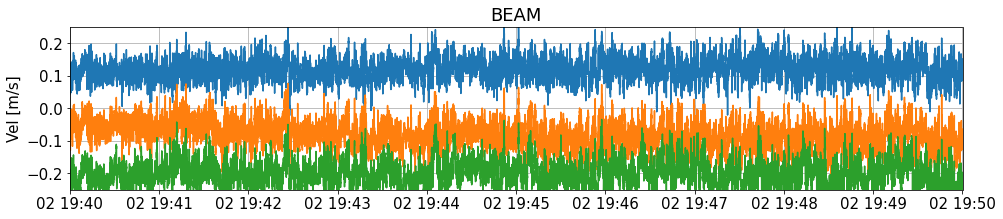

In [22]:
print(pto_small.BEAM_2_XYZ)
pto_plot(pto_small, '*', xl=xl)

This still needs to be confirmed
Unwrapping 0
Unwrapping 1
Doing incomplete block.
Phase unwrapping comlete.
This still needs to be confirmed
This still needs to be confirmed
This still needs to be confirmed


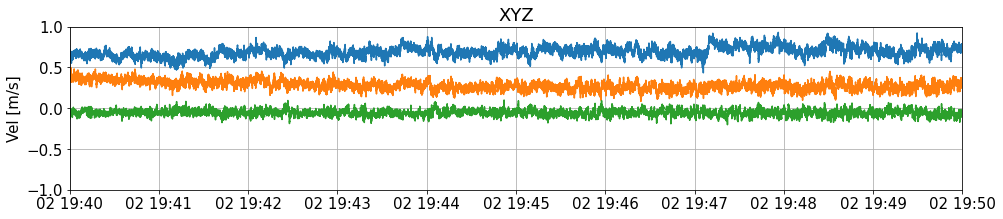

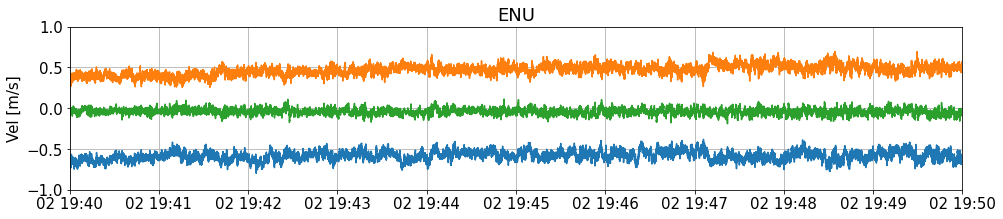

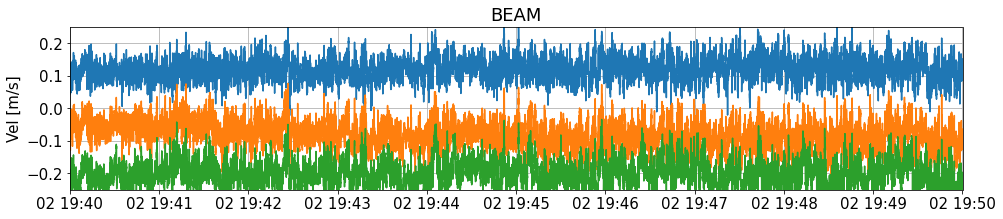

In [31]:
pto_small.clean_unwrap(block_length_seconds=600)
pto_plot(pto_small, '*', xl=xl)

### Compare the above to the MATLAB output for the same period
![title](../figures/matlab_comparison_figures/adv_processing_2_april/KISSME_April_2_6019_ADV_Raw_vs_Clean_[10_mins_from_1940].png)